### Retrieval-Augmented Generation (RAG) - Advanced -  Multi Query Translation
**Problem:** User queries are challenging. If user provides an ambiguous query, they will get ambiguous matches. 
             LLMs just follow what was in the context and produce the results as it is.

**Solution:** There are multiple ways to tackle the above problem.

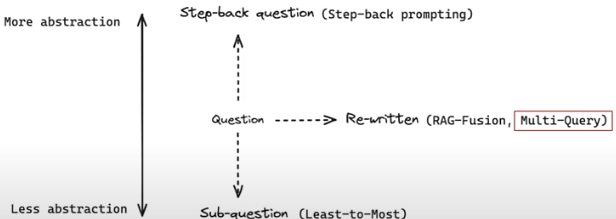
             
- More Abstraction: Refers to generalizing or stepping back to view the question from a higher-level perspective.
  - Example: Instead of directly asking for a specific answer, you might frame a question like, "What broader concepts should I consider for this problem?"
- Less Abstraction: Refers to breaking the question into specific, granular sub-questions that are easier to answer..
  - Example: For the question, "How does climate change affect agriculture?" sub-questions might be:
    - "What is climate change?"
    - "What are the main impacts of climate change on crop growth?"
- Rewriting the query using RAG-Fusion or Multi-Query
  - **RAG-Fusion**: Combining retrieved documents or information from multiple sources to provide a more comprehensive context.
  - **Multi-Query**: Generating multiple variations of the question to improve the chances of retrieving relevant information.

This section discusses on Multi-Query Translation in RAG

##### Key Highlights:
- **Implement Multi-Query Translation**
  - The question is broke into multiple questions based on different perspectives. This increases the likelihood of retrieving relevant information from the vector store.
  - Each question is sent to the retriever and fetches the relevant chunk from the vector store.

    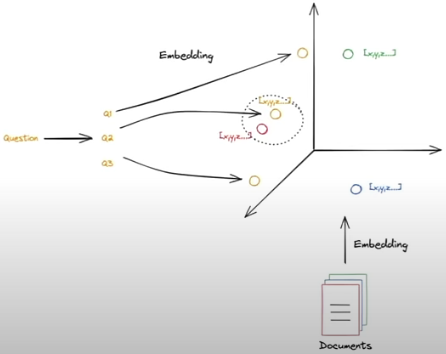
    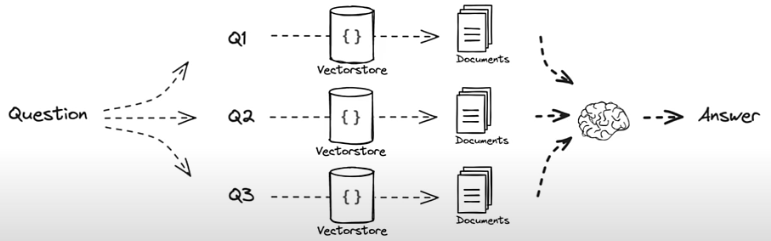
  

##### What's Next: 


#### Install required libraries

In [24]:
# Install required libraries
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


#### Import required libraries

In [25]:
import os # Operating system relevant tasks
from dotenv import load_dotenv
import bs4 # Import Beautiful Soap, a Python Web Scrapping package
from langchain_community.document_loaders import WebBaseLoader # Load documents from website
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma # Import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain import hub # Python library containing pre-defined Prompts, Chains for LLM applications
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.prompts import ChatPromptTemplate
import numpy as np
from langchain.load import dumps, loads
from operator import itemgetter

#### Environment Setup

In [26]:
# Load environment variables from .env file
load_dotenv()

# API key provides authentication to access LangChain service 
os.environ['LANGCHAIN_TRACING_V2'] = 'true' # Enables LangChain Tracing V2, a mechanism to enable and monitor the execution of LangChain applications for debugging and optimization
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com' # Configures the LangChain API End Point to use LangChain for tracing
os.environ['LANGCHAIN_API_KEY'] = os.getenv("LANGCHAIN_API_KEY")
# API key to access OpenAI services
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

#### RAG Process

##### Load, Split, Index

In [27]:
## Load Documents
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load() 

## Split the documents based on tokens
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=300, chunk_overlap=50)
splits = text_splitter.split_documents(blog_docs)

## Calculate the vector embeddings of the splits, store in the vector store and convert the vector store into a retriever object
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings()) # Store the vector embeddings of splits in Chroma DB

## Retrieve the documents that are closing matching with prompt using KNN
retriever = vectorstore.as_retriever(search_kwargs={"k": 5}) 

#### **Prompt - Generate multiple queries**
Write a Prompt in such a way that the query is converted into multiple queries utilizing the capability of LLM model

In [28]:
# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by newlines. Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

generate_queries = (
    prompt_perspectives 
    | ChatOpenAI(temperature=0) 
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

generate_queries

ChatPromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='You are an AI language model assistant. Your task is to generate five \ndifferent versions of the given user question to retrieve relevant documents from a vector \ndatabase. By generating multiple perspectives on the user question, your goal is to help\nthe user overcome some of the limitations of the distance-based similarity search. \nProvide these alternative questions separated by newlines. Original question: {question}'), additional_kwargs={})])
| ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x128f9a610>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x128fdc510>, root_client=<openai.OpenAI object at 0x128fca190>, root_async_client=<openai.AsyncOpenAI object at 0x128f98050>, temperature=0.0, model_kwar

In [29]:
def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
question = "What is task decomposition for LLM agents?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})
len(docs)

3

This is how trace in LangSmith looks like.
- Five queries are generated from the LLM as shown in the Figure.
- Retrieved five documents for each query from the vector store. So, five VectorStore Retrievers are seen.
- The distinct documents from the total retrieved documents are selected. Only 4 such distinct documents are found after getting the union of unique documents.
    - The reason is same document is retrieved multiple times for a given query. Same documents are retrieved in all queries. So, the number came out to be just 4.
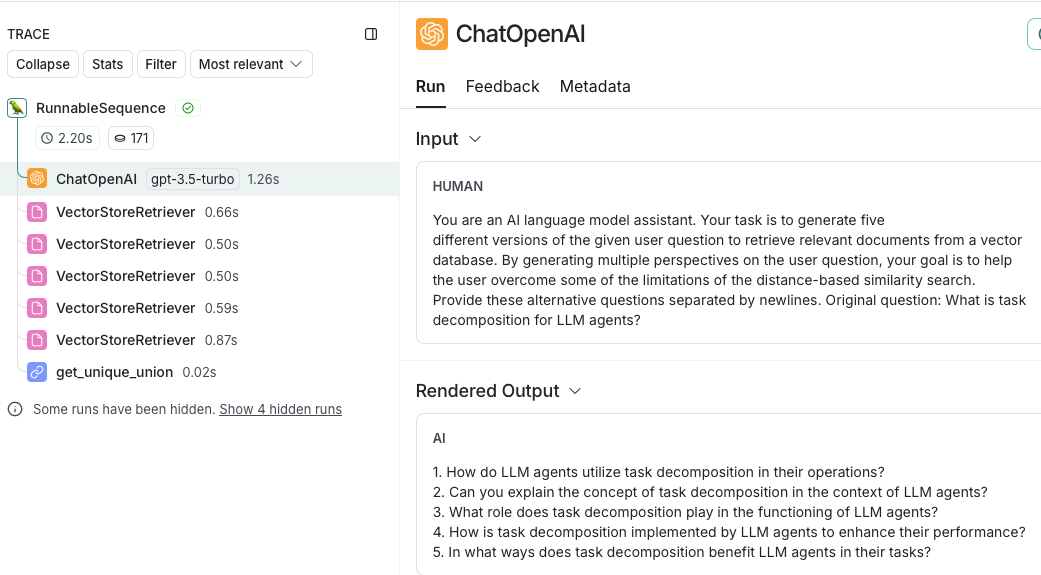

#### LLM, Invokde

In [30]:
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

# Define LLM
llm = ChatOpenAI(temperature=0)

final_rag_chain = (
    {"context": retrieval_chain, "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

# Invoke LLM
final_rag_chain.invoke({"question":question})

'Task decomposition for LLM agents involves breaking down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks. This process can be facilitated through techniques such as Chain of Thought and Tree of Thoughts, which help the model decompose hard tasks into smaller and simpler steps. Task decomposition can be achieved through simple prompting by LLM, task-specific instructions, or human inputs.'

**Few Takeaways:**

Why Multi-Query Translation in RAG?
- Improves Recall: By generating multiple queries, the system retrieves information from different angles, reducing the chance of missing relevant data.
- Handles Vocabulary Mismatch
- Diversified Results
- Robustness to Noise

Challenges with Multi-Query Translation?
- Computational Overhead: Generating multiple queries and retrieving for each one can be resource-intensive.
- Redundancy: If the same documents are retrieved across multiple queries, there may be overlapping or redundant information.
- Merging Complexity: Combining the retrieved results while ensuring relevance and avoiding noise can be tricky.